In [70]:
import numpy as np
from matplotlib import pyplot as plt
import math
import planet_sampler_pop as ps
import pandas as pd
from scipy import stats  
import scipy.optimize as opt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def snr_weiss(R_p, R_star, M_star, period, CDPP_6h):
    """
    snr_weiss : Computes the expected signal to noise ratio of a planet with size R_p and orbital period
    period orbiting a star with bulk density rho_star and radius R_star and a 6hr combined differential photometric precision 
    CDPP_6hr. This definition is taken from Weiss et al. 2018 https://iopscience.iop.org/article/10.3847/1538-3881/aa9ff6
    #####
    Parameters : 
    R_p : planet radius in Earth radius
    R_star : host star radius in solar radius
    M_star: host star mass in stellar mass
    period : period in days
    CDPP_6h : combined differential photometric precision over 6hr
    
    returns the value of SN ratio
    """
    R_sun = 695700
    R_earth = 6378
    M_sun = 1.989 * 10**30
    R_p_km = R_p * R_earth
    R_star_km = R_sun * R_star
    M_star_kg = M_star * M_sun
    rho_star = M_star/(R_star**3)
    depth = 1000000*(R_p_km / R_star_km)**2
    T = 13 * (period/365.24)**(1/3) * (rho_star)**(-1/3) # Parameter T in hours
    #print("period : " + str(period))
    #print("radius : " + str(R_p))
    #print("duration : " + str(T))
    #print("depth : " + str(depth))
    return  ((depth * math.sqrt(3.5 *365.24/ (period ))) / (CDPP_6h * math.sqrt(6/T)))


def swapping_criterion(R_p, R_star, M_star, period, CDPP_6h, snr_threshold = 10):
    return (snr_weiss(R_p, R_star, M_star, period, CDPP_6h) > snr_threshold)
    
    
def gaussian_fit(x, mu, sigma):
    return 1/math.sqrt(2*math.pi*sigma**2) * np.exp(-(x - mu)**2/(2*sigma**2))
def skew_gaus(x, mean, skew, sigma):
    return stats.skewnorm.pdf(x, skew, mean, sigma)
def rejection_sampling(func, x_vals, n_of_points):
    curve = func(x_vals)
    max_func = max(curve)
    x_sampled = np.random.choice(x_vals, size = n_of_points)
    y_sampled = np.random.uniform(high = max_func, size = n_of_points)
    rejected_points = y_sampled > func(x_sampled)
    n_of_points = np.count_nonzero(rejected_points)
    while(n_of_points >0):
        x_sampled[rejected_points] = np.random.choice(x_vals, size = n_of_points)
        y_sampled[rejected_points] = np.random.uniform(high = max_func, size = n_of_points)
        rejected_points = y_sampled > func(x_sampled)
        n_of_points = np.count_nonzero(rejected_points)
    return x_sampled

# Loading data

In [2]:
#kam_planets = ps.PlanetSample("emile_testing_AG13_bright5_baseline.txt", dataset = "SAG")
#life_planets = ps.PlanetSample("emile_testing_AG13_bright5_weiss.txt", dataset = "SAG")
weiss_planets = pd.read_csv("weiss_tables.csv")

# Radius part

In [101]:
count = 0
Rps_plus_weiss = []
Rps_minus_weiss = []
for star in weiss_planets['host_star'].unique(): # loop on all stars
    mask = weiss_planets['host_star'] == star
    periods = weiss_planets[mask].planet_period
    sorting = np.argsort(periods)
    periods = periods.iloc[sorting]
    radius_p = weiss_planets[mask].planet_radius.iloc[sorting]
    radius_star = weiss_planets[mask].star_radius.iloc[sorting]
    mass_star = weiss_planets[mask].star_mass.iloc[sorting]
    CDPP = weiss_planets[mask].CDPP_6h.iloc[sorting]
    if(len(periods) > 1): # If the star has a system with more than one planet
        for i in range(len(periods) - 1): # we loop over all the planet pairs of the system
            smallest_radius = min(radius_p.iloc[i], radius_p.iloc[i+1])
            largest_p = max(periods.iloc[i], periods.iloc[i+1])
            if(swapping_criterion(smallest_radius, radius_star.iloc[i], mass_star.iloc[i], largest_p,CDPP.iloc[i] , snr_threshold = 10)):
                Rps_temp = radius_p
                Rps_temp_plus = Rps_temp.iloc[i+1]
                Rps_temp_minus = Rps_temp.iloc[i]
                Rps_plus_weiss.append(Rps_temp_plus)
                Rps_minus_weiss.append(Rps_temp_minus)
            else:
                #print("The pair did not pass the swapping criterion")
                count += 1
            
    else:
        pass
Rps_plus_weiss = np.array(Rps_plus_weiss)
Rps_minus_weiss = np.array(Rps_minus_weiss)

print(count)

63


In [102]:
len(Rps_plus_weiss)

491

(0.4867153713520361, 1.4430566926714523e-30)


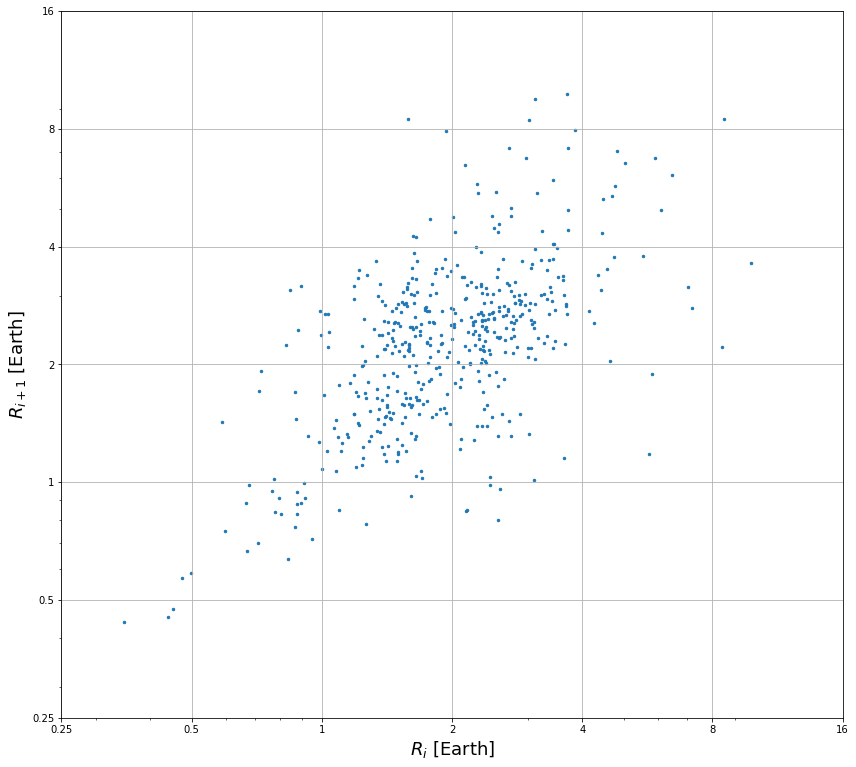

In [5]:
plt.figure(figsize = (14,13))
plt.scatter((Rps_minus_weiss), (Rps_plus_weiss), s = 6, linewidth = 1)
plt.ylabel("$R_{i+1}$ [Earth]", fontsize = 18)
plt.xlabel("$R_{i}$ [Earth]", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.yticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.grid()
print(stats.pearsonr(Rps_minus_weiss, Rps_plus_weiss))

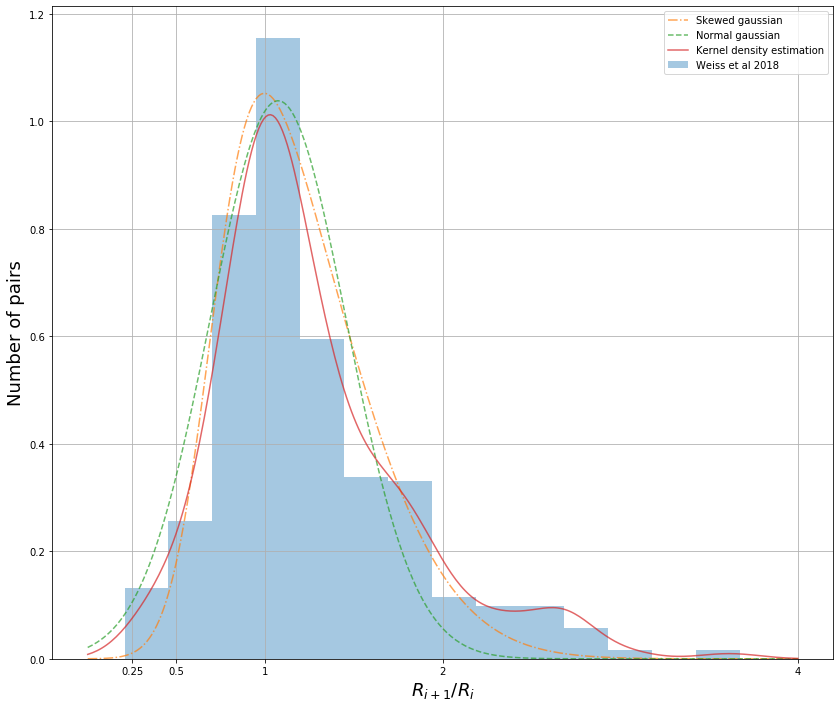

In [6]:
plt.figure(figsize = (14,12))
temp = (Rps_plus_weiss /Rps_minus_weiss) 
temp = temp[(temp < 4)]
std = np.std(temp)
h_scott = 3.5 * std / (len(temp)**(1/3)) # computing bin width
n_of_bins = (max(temp) - min(temp))/h_scott
entries, bin_edges, patches  =plt.hist(temp, int(n_of_bins), density=True, alpha = 0.4, label = "Weiss et al 2018")
x_plot = np.linspace(0,4, 300)
kernel = stats.gaussian_kde(temp)
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
popt_gauss, pcov_gauss = opt.curve_fit(gaussian_fit, bin_middles,entries )
popt_skew, pcov_skew = opt.curve_fit(skew_gaus, bin_middles, entries, p0 = [1.1, 1, 3.5])
plt.plot(x_plot, skew_gaus(x_plot, popt_skew[0], popt_skew[1], popt_skew[2]), alpha = 0.7, label = "Skewed gaussian", ls ="-.")
plt.plot(x_plot, gaussian_fit(x_plot, popt_gauss[0], popt_gauss[1]), alpha = 0.7, label = "Normal gaussian", ls = "--")
plt.plot(x_plot, kernel(x_plot), label = "Kernel density estimation", alpha = 0.7)
plt.xlabel("$R_{i+1} / R_i$", fontsize = 18)
plt.ylabel("Number of pairs", fontsize = 18)
plt.xticks([0.25,0.5,1,2,4], [0.25,0.5,1,2,4])
plt.grid()
plt.legend()
plt.savefig("kernel.png")

In [48]:
nsim = 1000000
skewed_sim = stats.skewnorm(a = popt_skew[1], loc = popt_skew[0], scale = popt_skew[2]).rvs(nsim)
gaus_sim = np.random.normal(loc = popt_gauss[0], scale = popt_gauss[1], size = nsim)
gaus_ks = stats.ks_2samp(temp, gaus_sim)
skewed_ks = stats.ks_2samp(temp, skewed_sim)
#kernel_sim = rejection_sampling(kernel, x_plot, nsim)
#kernel_ks = stats.ks_2samp(temp, kernel_sim)
kernel_sim2 = kernel.resample(nsim)[0]
kernel_ks2  = stats.ks_2samp(temp, kernel_sim2)
print("Results when comparing the original distribution with a sample of size " + str(nsim))
print("p-value gaussian case : " + str(gaus_ks.pvalue))
print("p-value skew case : " + str(skewed_ks.pvalue))
#print("p-value kernel case : " + str(kernel_ks.pvalue))
print("p-value kernel case2 " + str(kernel_ks2.pvalue))


Results when comparing the original distribution with a sample of size 1000000
p-value gaussian case : 6.993606645995392e-08
p-value skew case : 0.019590682692477157
p-value kernel case 2 0.41302576140992514
rejection : 39.06430387496948
resample : 0.15450358390808105


In [54]:
dataset_radii = kernel.dataset

In [100]:
len(dataset_radii[0])

489

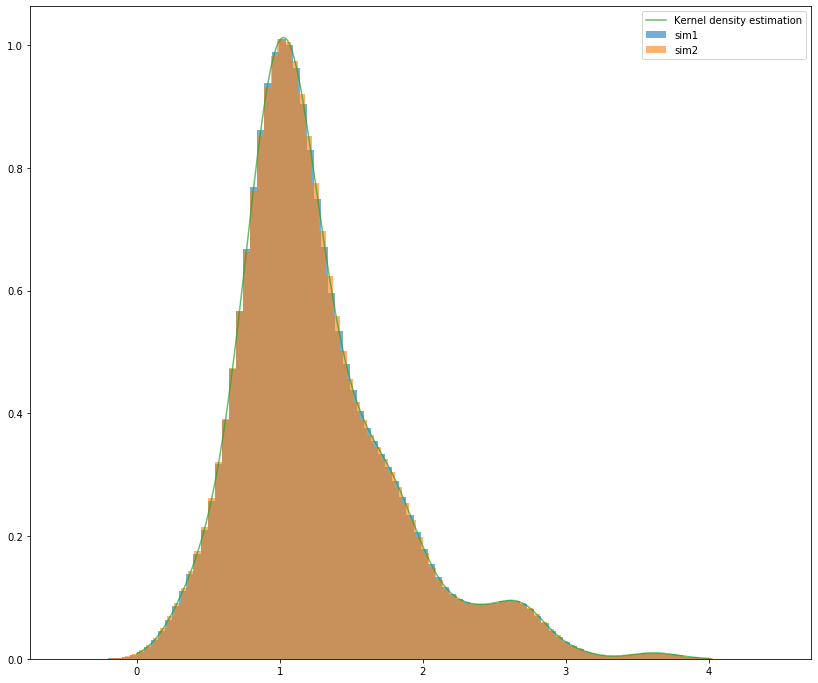

In [59]:
plt.figure(figsize = (14,12))
plt.hist(a, alpha = 0.6, label = "sim1", density = True, bins = 100)
plt.hist(b, alpha = 0.6, label = "sim2", density = True, bins = 100)
plt.plot(x_plot, kernel(x_plot), label = "Kernel density estimation", alpha = 0.7)
plt.legend()
plt.show()

# Correlating distances

In [89]:
periods_plus = []
periods_minus = []
periods_ratio = []
count = 0
for kois in weiss_planets.KOIS.unique():
    mask = weiss_planets['KOIS'] == kois
    periods = np.array(weiss_planets[mask].planet_period)
    sorting = np.argsort(periods)
    periods = periods[sorting]
    radius_p = weiss_planets[mask].planet_radius.iloc[sorting]
    radius_star = weiss_planets[mask].star_radius.iloc[sorting]
    mass_star = weiss_planets[mask].star_mass.iloc[sorting]
    CDPP = weiss_planets[mask].CDPP_6h.iloc[sorting]
    if(len(periods) >= 3 ):
        count += 1
        periods_temp_ratio = periods[1:]/periods[:-1]
        periods_temp_plus = periods[2:]/(periods[1:-1])
        periods_temp_minus = periods[1:-1]/periods[0:-2]
        periods_ratio.append(periods_temp_ratio)
        periods_plus.append(periods_temp_plus)
        periods_minus.append(periods_temp_minus)
periods_ratio = np.concatenate(periods_ratio)
periods_ratio = periods_ratio[periods_ratio <= 4]
periods_plus = np.concatenate(np.array(periods_plus))
periods_minus = np.concatenate(np.array(periods_minus))
periods_plus_weiss = periods_plus[np.logical_and(periods_minus <= 4, periods_plus <= 4)]
periods_minus_weiss = periods_minus[np.logical_and(periods_minus <= 4, periods_plus <= 4)]

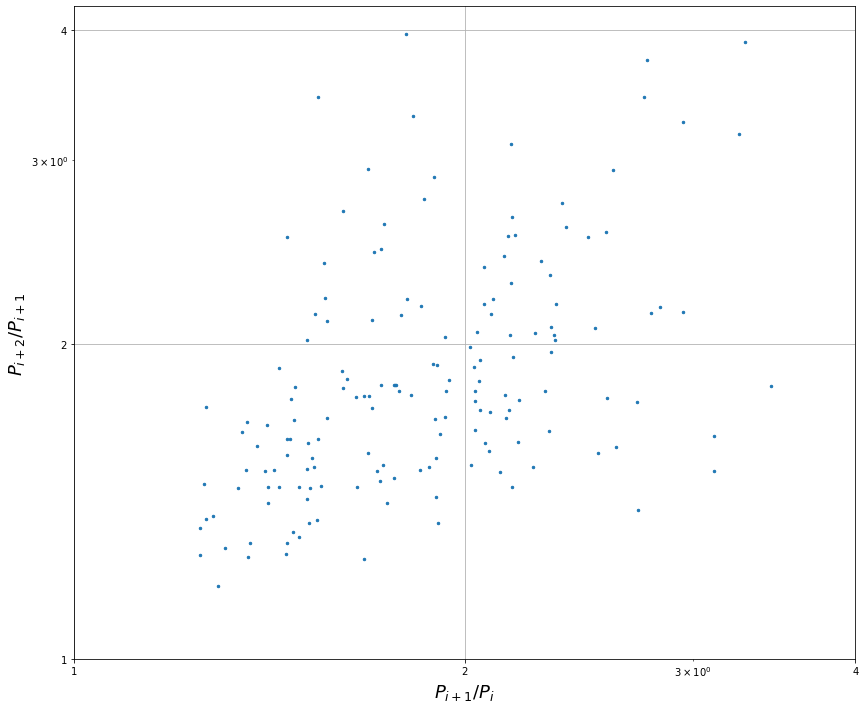

In [90]:
plt.figure(figsize = (14,12))
plt.scatter(periods_minus_weiss, periods_plus_weiss, s = 6, linewidth = 1)
plt.ylabel("$P_{i+2}/P_{i+1}$ ", fontsize = 18)
plt.xlabel("$P_{i+1}/P_i$", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([1,2,4], [1,2,4])
plt.yticks([1,2,4], [1,2,4])
plt.grid()

Results when comparing the original distribution with a sample of size 100000
p-value gaussian case : 0.40171266892624774
p-value skew case : 0.5447126014315101
p-value kernel case : 0.7428367609805959


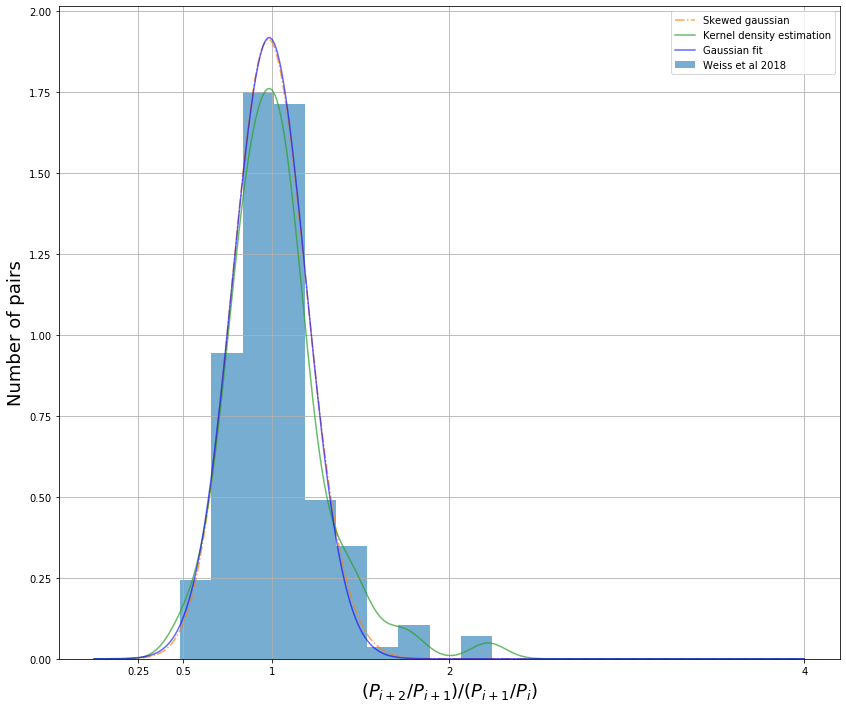

In [91]:
plt.figure(figsize = (14,12))
temp = (periods_plus_weiss /periods_minus_weiss) 
temp = temp[(temp < 4)]
std = np.std(temp)
h_scott = 3.5 * std / (len(temp)**(1/3)) # computing bin width
n_of_bins = (max(temp) - min(temp))/h_scott
entries, bin_edges, patches  =plt.hist(temp, bins = int(n_of_bins), density=True, alpha = 0.6, label = "Weiss et al 2018")
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
popt_skew, pcov_skew = opt.curve_fit(skew_gaus, bin_middles, entries, p0 = [1.1, 1, 3.5])
plt.plot(x_plot, skew_gaus(x_plot, popt_skew[0], popt_skew[1], popt_skew[2]), alpha = 0.7, label = "Skewed gaussian", ls ="-.")
kernel = stats.gaussian_kde(temp)
plt.plot(x_plot, kernel(x_plot), label = "Kernel density estimation", alpha = 0.7)
popt_gauss, pcov_gauss = opt.curve_fit(gaussian_fit, bin_middles,entries )
x_plot = np.linspace(0,4, 300)
plt.plot(x_plot, gaussian_fit(x_plot, popt_gauss[0], popt_gauss[1]), color = "b", alpha = 0.6, label ="Gaussian fit")
plt.xlabel("$(P_{i+2} / P_{i+1}) / (P_{i+1} / P_{i})$", fontsize = 18)
plt.ylabel("Number of pairs", fontsize = 18)
plt.xticks([0.25,0.5,1,2,4], [0.25,0.5,1,2,4])
plt.grid()
plt.legend()

####### Comparing the original data with our simulations


nsim = 100000
skewed_sim = stats.skewnorm(a = popt_skew[1], loc = popt_skew[0], scale = popt_skew[2]).rvs(nsim)
gaus_sim = np.random.normal(loc = popt_gauss[0], scale = popt_gauss[1], size = nsim)
gaus_ks = stats.ks_2samp(temp, gaus_sim)
skewed_ks = stats.ks_2samp(temp, skewed_sim)
kernel_sim = kernel.resample(nsim)[0]
kernel_ks = stats.ks_2samp(temp, kernel_sim)
print("Results when comparing the original distribution with a sample of size " + str(nsim))
print("p-value gaussian case : " + str(gaus_ks.pvalue))
print("p-value skew case : " + str(skewed_ks.pvalue))
print("p-value kernel case : " + str(kernel_ks.pvalue))

## Skew seems close to kernel but the results might differ depending on the number of bins that we choose to
# take, thus kernel seems better ?

In [106]:
dataset_distances = kernel.dataset

In [107]:
np.savetxt("distances.py",dataset_distances, delimiter=',')

# Correlating periods

Results when comparing the original distribution with a sample of size 10000000
p-value gaussian case : 1.85147046035311e-05
p-value skew case : 0.5684710106499864
p-value kernel case : 0.5884005459174695


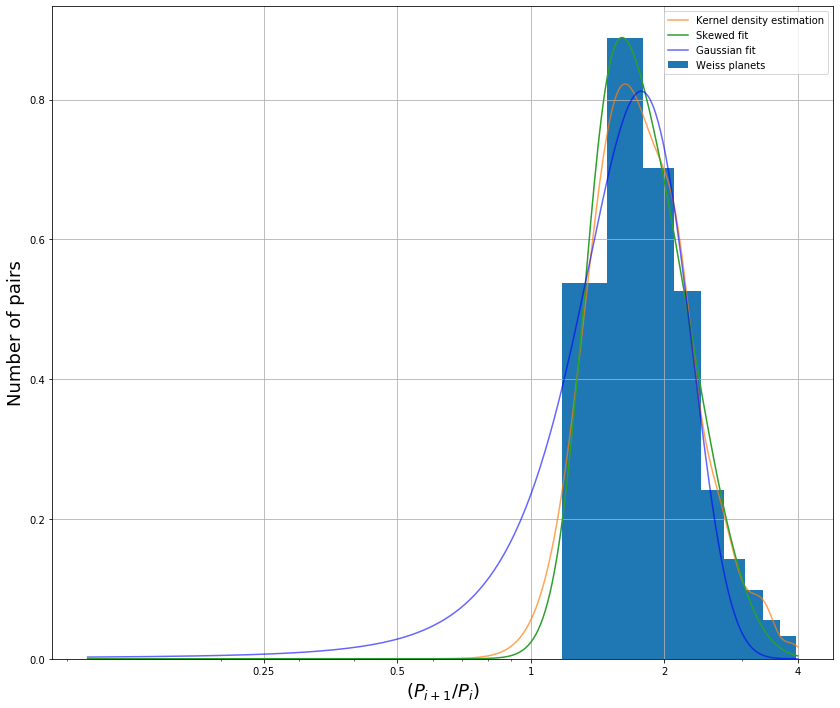

In [116]:
std_periods = np.std(periods_ratio)
h_scott_periods = 3.5 * std_periods / (len(periods_ratio)**(1/3)) # computing bin width
n_of_bins_periods = (max(periods_ratio) - min(periods_ratio))/h_scott_periods
plt.figure(figsize = (14,12))
entries, bin_edges, patches = plt.hist(periods_ratio, bins = int(n_of_bins_periods), density = True, label = "Weiss planets")
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
kernel_periods = stats.gaussian_kde(periods_ratio)
popt_skew, pcov_skew = opt.curve_fit(skew_gaus, bin_middles, entries, p0 = [1.5, 10, 3.5])
popt_gauss, pcov_gauss = opt.curve_fit(gaussian_fit, bin_middles,entries )
lsp = np.linspace(0.1,4,300)
plt.plot(lsp, kernel_periods(lsp), label = "Kernel density estimation", alpha = 0.7)
plt.plot(lsp, skew_gaus(lsp, popt_skew[0], popt_skew[1], popt_skew[2]), label = "Skewed fit")
plt.plot(lsp, gaussian_fit(lsp, popt_gauss[0], popt_gauss[1]), color = "b", alpha = 0.6, label ="Gaussian fit")
plt.xscale("log")
plt.xlabel("$(P_{i+1} / P_{i})$", fontsize = 18)
plt.ylabel("Number of pairs", fontsize = 18)
plt.xticks([0.25,0.5,1,2,4], [0.25,0.5,1,2,4])
plt.grid()
plt.legend()

####### Comparing the original data with our simulations


nsim = 10000000
skewed_sim = stats.skewnorm(a = popt_skew[1], loc = popt_skew[0], scale = popt_skew[2]).rvs(nsim)
gaus_sim = np.random.normal(loc = popt_gauss[0], scale = popt_gauss[1], size = nsim)
gaus_ks = stats.ks_2samp(periods_ratio, gaus_sim)
skewed_ks = stats.ks_2samp(periods_ratio, skewed_sim)
kernel_sim = kernel_periods.resample(nsim)[0]
kernel_ks = stats.ks_2samp(periods_ratio, kernel_sim)
print("Results when comparing the original distribution with a sample of size " + str(nsim))
print("p-value gaussian case : " + str(gaus_ks.pvalue))
print("p-value skew case : " + str(skewed_ks.pvalue))
print("p-value kernel case : " + str(kernel_ks.pvalue))

In [99]:
len(periods_ratio)

294

In [120]:
dataset_periods = kernel_periods.dataset 

In [121]:
np.savetxt("periods_da.py",dataset_periods, delimiter=',')